Next steps:
1. Add a "master node" that connects all nodes together, so that message passing works between all nodes

In [1]:
import pandas as pd

from EmbedDataset import LigandBinaryDataset

import time
import numpy as np
import torch
from torch_geometric.loader import DataLoader

In [2]:
dataset = LigandBinaryDataset('./data2/')

In [3]:
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

In [4]:
train_dl = DataLoader(train_dataset, batch_size=16)
val_dl = DataLoader(val_dataset, batch_size=16)
test_dl = DataLoader(test_dataset, batch_size=16)

In [5]:
from LigandGNNV2 import LigandGNNV2
from LigandGNNV1 import LigandGNNV1
from sagn.models import SAGN

device = torch.device('cuda')
# model = LigandGNNV1(dataset.num_node_features, 1).to(device)
model = LigandGNNV2(128, 42).to(device)
# model = SAGN(in_feats=1070, hidden=1024, out_feats=1, num_hops=5, n_layers=2, num_heads=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([22]).to(device))

In [6]:
def train(model, loader, criterion, optimizer):
    model.train()

    loss_acc = 0.
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y

        loss = criterion(output, label.reshape(-1, 1))
        loss.backward()
        loss_acc += data.num_graphs * loss.item()
        optimizer.step()

    return loss_acc / len(loader.dataset)

In [7]:
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, precision_recall_fscore_support, roc_auc_score

def evaluate(model, loader):
    model.eval()

    preds = np.asarray([])
    labels = np.asarray([])

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = torch.sigmoid(model(data).round().squeeze().cpu()).round().numpy()
            label = data.y.cpu().numpy()

            preds = np.concatenate([preds, pred])
            labels = np.concatenate([labels, label])

    precision, recall, _ = precision_recall_curve(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
    print(precision_recall_fscore_support(labels, preds))
    return auc(fpr, tpr), auc(recall, precision)
    return roc_auc_score(labels, preds)

In [8]:
train_hist = []
val_hist = []

for epoch in range(1, 201):
    s = time.time()
    loss = train(model, train_dl, criterion, optimizer)
    train_score = evaluate(model, train_dl)
    val_score = evaluate(model, val_dl)
    scheduler.step(loss)
    e = time.time()

    train_hist.append(train_score)
    val_hist.append(val_score)

    if sum(val_score) > (.77 + .44) and sum(val_score) >= np.asarray(val_hist).sum(axis=1).max():
        print("saving...")
        torch.save(model.state_dict(), './models/BestModel2.pt')

    # print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score:.05f}, Val Score: {val_score:.05f}, Time: {e - s:.05f}s')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.05f}, Train Score: {train_score}, Val Score: {val_score}, Time: {e - s:.05f}s')

C:\Users\billb\anaconda3\envs\watai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.96560191, 0.        ]), array([1., 0.]), array([0.98249997, 0.        ]), array([341348,  12160], dtype=int64))


C:\Users\billb\anaconda3\envs\watai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.96558977, 0.        ]), array([1., 0.]), array([0.98249369, 0.        ]), array([63811,  2274], dtype=int64))
Epoch: 001, Loss: 1.23038, Train Score: (0.5, 0.517199045000396), Val Score: (0.5, 0.517205114625104), Time: 20.97708s
(array([0.98242573, 0.1081744 ]), array([0.82849467, 0.58396382]), array([0.89891801, 0.1825356 ]), array([341348,  12160], dtype=int64))
(array([0.9846107 , 0.10839006]), array([0.81114541, 0.64423923]), array([0.88949991, 0.18556048]), array([63811,  2274], dtype=int64))
Epoch: 002, Loss: 1.03815, Train Score: (0.7062292449232238, 0.353224530560125), Val Score: (0.727692319916775, 0.38243554602674823), Time: 14.39500s
(array([0.98858541, 0.09939254]), array([0.7563425 , 0.75485197]), array([0.85700866, 0.17565615]), array([341348,  12160], dtype=int64))
(array([0.98984898, 0.09916162]), array([0.74573349, 0.78540018]), array([0.85062341, 0.17609071]), array([63811,  2274], dtype=int64))
saving...
Epoch: 003, Loss: 0.94841, Train Score: (0.7555972372

KeyboardInterrupt: 

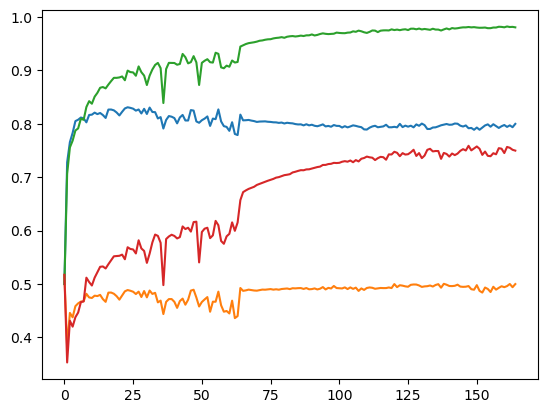

In [9]:
import matplotlib.pyplot as plt
plt.plot(val_hist)
plt.plot(train_hist)
plt.show()

In [10]:
evaluate(model, test_dl)

(array([0.98008844, 0.35144268]), array([0.96662341, 0.47943262]), array([0.97330936, 0.40557972]), array([74753,  2820], dtype=int64))


(0.7230280186103207, 0.4248997084581403)

In [12]:
model.load_state_dict(torch.load('./models/BestModel2.pt'))
evaluate(model, test_dl)

(array([0.98735333, 0.18360138]), array([0.88251977, 0.70035461]), array([0.93199782, 0.2909332 ]), array([74753,  2820], dtype=int64))


(0.7914371875110588, 0.44742447555662)

In [13]:
data = test_dl.dataset[4].to(device)

In [14]:
pred = model(data)

In [15]:
out = torch.sigmoid(pred).round()
out

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [16]:
print(out.sum())
print(len(out))

tensor(65., device='cuda:0', grad_fn=<SumBackward0>)
403


In [17]:
len(data.y) / data.y.sum()

tensor(17.5217, device='cuda:0')

In [18]:
data.y.sum()

tensor(23., device='cuda:0')

In [19]:
f1_score(data.y.detach().cpu().numpy(), out.detach().cpu().numpy())

0.38636363636363635

In [ ]:
torch.save(model.state_dict(), './models/modelBest.pt')